belkacem dounia 





# **TP07 : Détection et Segmentation de Contours Fermés par Filtre de Kirsch**

---

## **1. Objectif**

L’objectif de ce TP est de détecter et segmenter automatiquement les **contours fermés** dans une image en niveaux de gris.  
Pour cela, on utilise successivement :
- le **filtre de Kirsch** (pour la détection multi-directionnelle des bords),
- la **méthode d’Otsu** (pour le seuillage automatique des contours),
- puis une étape de **segmentation et vérification des contours fermés** à l’aide d’outils morphologiques.

---

## **2. Méthodologie**

### **2.1. Détection des contours avec le filtre de Kirsch**

(expliquee dans le tp precedent)
### **2.2. Seuillage automatique par la méthode d’Otsu**
(expliquee dans le tp precedent)
.

### **2.3. Segmentation et vérification des contours fermés**

- On utilise la fonction `cv2.findContours` pour extraire tous les contours de l’image binaire.
- On vérifie la fermeture des contours (ici via la convexité) et on ne conserve que les contours fermés.
- Les contours fermés sont ensuite dessinés et remplis pour obtenir une image segmentée des objets détectés.

---

## **3. Résultats**
- L’étape de segmentation permet d’isoler et de visualiser uniquement les **contours fermés**, correspondant souvent à des objets ou régions d’intérêt.
---
## **4. Conclusion**

La combinaison du **filtre de Kirsch** (pour la détection multi-directionnelle des contours), du **seuillage automatique d’Otsu** (pour la binarisation) et de l’**analyse morphologique** (pour la segmentation des contours fermés) permet d’obtenir une segmentation robuste et automatisée des objets fermés dans une image.  


Seuil automatique (Otsu) = 111


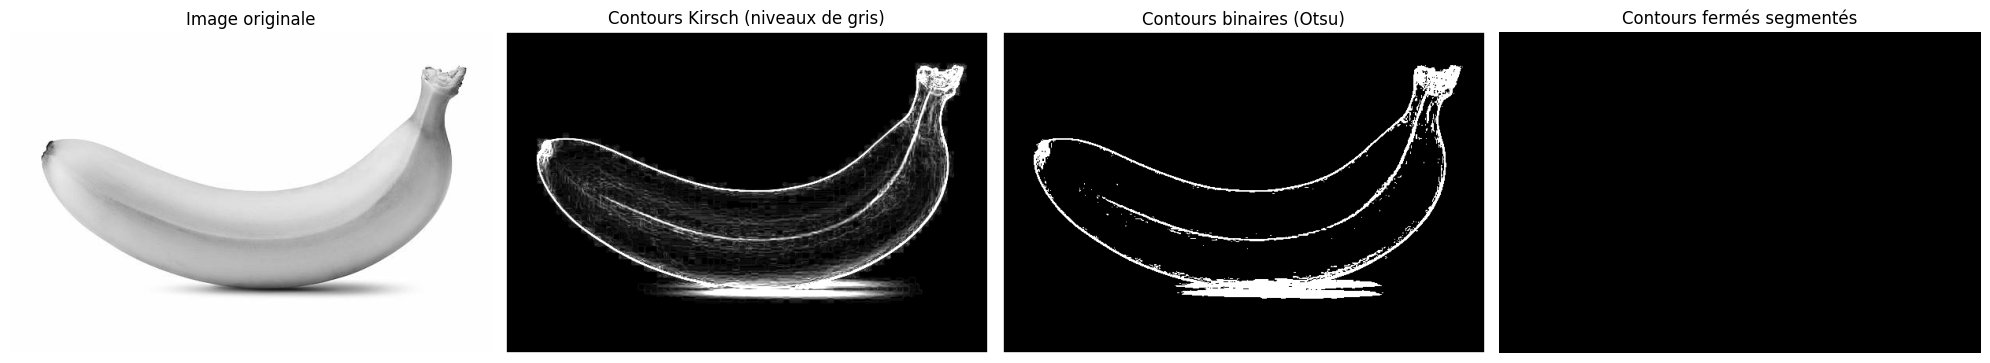

Nombre de contours fermés détectés : 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# --- Étape 1 : Charger et convertir l'image ---
image_path = r"C:\Users\DELL\Desktop\tp_tim\pics\bananapic.jpg"
image = Image.open(image_path).convert('L')
image_array = np.array(image)

# --- Étape 2 : Définir les 8 masques de Kirsch ---
kirsch_kernels = [
    np.array([[ 5,  5,  5],
              [-3,  0, -3],
              [-3, -3, -3]]),  # Nord
    np.array([[ 5,  5, -3],
              [ 5,  0, -3],
              [-3, -3, -3]]),  # Nord-Est
    np.array([[ 5, -3, -3],
              [ 5,  0, -3],
              [ 5, -3, -3]]),  # Est
    np.array([[-3, -3, -3],
              [ 5,  0, -3],
              [ 5,  5, -3]]),  # Sud-Est
    np.array([[-3, -3, -3],
              [-3,  0, -3],
              [ 5,  5,  5]]),  # Sud
    np.array([[-3, -3, -3],
              [-3,  0,  5],
              [-3,  5,  5]]),  # Sud-Ouest
    np.array([[-3, -3,  5],
              [-3,  0,  5],
              [-3, -3,  5]]),  # Ouest
    np.array([[-3,  5,  5],
              [-3,  0,  5],
              [-3, -3, -3]])   # Nord-Ouest
]

# --- Étape 3 : Appliquer le filtre de Kirsch ---
def apply_kirsch_filter(image, kernels):
    padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    rows, cols = image.shape
    responses = []

    for kernel in kernels:
        response = np.zeros_like(image, dtype=np.float32)
        for i in range(1, rows + 1):
            for j in range(1, cols + 1):
                region = padded_image[i-1:i+2, j-1:j+2]
                value = np.sum(region * kernel)
                response[i-1, j-1] = value
        responses.append(response)

    final_response = np.maximum.reduce(responses)
    return np.clip(final_response, 0, 255).astype(np.uint8)

# --- Étape 4 : Méthode d'Otsu pour le seuillage automatique ---
def otsu_threshold(image):
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))
    total_pixels = image.size

    current_max = 0
    threshold = 0
    sum_total = np.dot(np.arange(256), histogram)
    sum_background = 0
    weight_background = 0

    for t in range(256):
        weight_background += histogram[t]
        if weight_background == 0:
            continue

        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break

        sum_background += t * histogram[t]

        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground

        between_class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2

        if between_class_variance > current_max:
            current_max = between_class_variance
            threshold = t

    return threshold

# --- Étape 5 : 
def binarize_image(image, threshold):
    binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)
    return binary_image




def segment_and_verify_closed_contours(binary_image):
   
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    closed_contours = []
    for contour in contours:
        
        if cv2.isContourConvex(contour):
            closed_contours.append(contour)
    
   
    segmented_image = np.zeros_like(binary_image)
    cv2.drawContours(segmented_image, closed_contours, -1, (255), thickness=cv2.FILLED)
    
    return segmented_image, closed_contours


kirsch_edges = apply_kirsch_filter(image_array, kirsch_kernels)
threshold = otsu_threshold(kirsch_edges)
print(f"Seuil automatique (Otsu) = {threshold}")
binary_edges = binarize_image(kirsch_edges, threshold)


segmented_image, closed_contours = segment_and_verify_closed_contours(binary_edges)

# --- Affichage des résultats ---
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

axes[0].imshow(image_array, cmap='gray')
axes[0].set_title("Image originale")
axes[0].axis('off')

axes[1].imshow(kirsch_edges, cmap='gray')
axes[1].set_title("Contours Kirsch (niveaux de gris)")
axes[1].axis('off')

axes[2].imshow(binary_edges, cmap='gray')
axes[2].set_title("Contours binaires (Otsu)")
axes[2].axis('off')

axes[3].imshow(segmented_image, cmap='gray')
axes[3].set_title("Contours fermés segmentés")
axes[3].axis('off')

plt.tight_layout()
plt.show()
print(f"Nombre de contours fermés détectés : {len(closed_contours)}")